## Лабораторная работа №3

### Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.

__Цель лабораторной работы:__ изучение способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.

__Задание:__
1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
3.Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью подходящих для задачи метрик.
4. Произведите подбор гиперпараметра K с использованием GridSearchCV и/или RandomizedSearchCV и кросс-валидации, оцените качество оптимальной модели. Желательно использование нескольких стратегий кросс-валидации.
5. Сравните метрики качества исходной и оптимальной моделей.

### Текстовое описание набора данных

В качестве набора данных мы будем использовать набор данных [Graduate Admission 2](https://www.kaggle.com/mohansacharya/graduate-admissions?select=Admission_Predict.csv)

Файл Admission_Predict содержит следующие колонки:
- GRE Scores (out of 340) 
- TOEFL Scores (out of 120)
- University Rating (out of 5)
- Statementof Purpose and Letter of Recommendation Strength (out of 5)
- Undergraduate GPA (out of 10)
- Research Experience (either 0 or 1)
- Chance of Admit (ranging from 0 to 1)

### Импорт библиотек, загрузка данных, основные характеристики датасета

In [1]:
#Импорт библиотек
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [2]:
#Загрузка данных
data = pd.read_csv('data/Admission_Predict.csv', sep=",")

In [3]:
# Первые 5 строк датасета
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [4]:
# Размер датасета
data.shape

(400, 9)

In [5]:
# Список колонок с типами данных
data.dtypes

Serial No.             int64
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
Chance of Admit      float64
dtype: object

In [6]:
# Проверим наличие пустых значений
data.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [7]:
# Основные статистические характеристки набора данных
data.describe()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,200.500000,316.807500,107.410000,3.087500,3.400000,3.452500,8.598925,0.547500,0.724350
std,115.614301,11.473646,6.069514,1.143728,1.006869,0.898478,0.596317,0.498362,0.142609
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000,0.340000
25%,100.750000,308.000000,103.000000,2.000000,2.500000,3.000000,8.170000,0.000000,0.640000
50%,200.500000,317.000000,107.000000,3.000000,3.500000,3.500000,8.610000,1.000000,0.730000
75%,300.250000,325.000000,112.000000,4.000000,4.000000,4.000000,9.062500,1.000000,0.830000
max,400.000000,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


### Разделение выборки на обучающую и тестовую

In [8]:
# уберем ненужный для нас параметр, чтобы он не помешал в будущем
data.drop(['Serial No.'], axis = 1, inplace = True)

In [9]:
parts = np.split(data, [7,8], axis=1)
X = parts[0]
Y = parts[1]
print('Входные данные:\n', X.head(), '\n\nВыходные данные:\n', Y.head())

Входные данные:
    GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  Research
0      337.0        118.0                4.0  4.5   4.5  9.65       1.0
1      324.0        107.0                4.0  4.0   4.5  8.87       1.0
2      316.0        104.0                3.0  3.0   3.5  8.00       1.0
3      322.0        110.0                3.0  3.5   2.5  8.67       1.0
4      314.0        103.0                2.0  2.0   3.0  8.21       0.0 

Выходные данные:
    Chance of Admit 
0              0.92
1              0.76
2              0.72
3              0.80
4              0.65


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

In [11]:
print('Входные параметры обучающей выборки:\n',X_train.head(), \
      '\n\nВходные параметры тестовой выборки:\n', X_test.head(), \
      '\n\nВыходные параметры обучающей выборки:\n', Y_train.head(), \
      '\n\nВыходные параметры тестовой выборки:\n', Y_test.head())

Входные параметры обучающей выборки:
      GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  Research
268      327.0        113.0                4.0  4.5   5.0  9.14       0.0
204      298.0        105.0                3.0  3.5   4.0  8.54       0.0
171      334.0        117.0                5.0  4.0   4.5  9.07       1.0
62       304.0        105.0                2.0  3.0   3.0  8.20       1.0
385      335.0        117.0                5.0  5.0   5.0  9.82       1.0 

Входные параметры тестовой выборки:
      GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  Research
398      312.0        103.0                3.0  3.5   4.0  8.78       0.0
125      300.0        100.0                3.0  2.0   3.0  8.66       1.0
328      324.0        112.0                4.0  4.0   3.5  8.77       1.0
339      324.0        107.0                5.0  3.5   4.0  8.66       1.0
172      322.0        110.0                4.0  4.0   5.0  9.13       1.0 

Выходные параметры обучающей выбо

In [12]:
# Размер обучающей выборки
X_train.shape, Y_train.shape

((360, 7), (360, 1))

In [13]:
# Размер тестовой выборки
X_test.shape, Y_test.shape

((40, 7), (40, 1))

### Модель ближайших соседей для произвольного гиперпараметра K

In [14]:
# Решение задачи регрессии методом 2, 5 и 10 ближайших соседей
Regressor_2NN = KNeighborsRegressor(n_neighbors = 2) 
Regressor_5NN = KNeighborsRegressor(n_neighbors = 5)
Regressor_10NN = KNeighborsRegressor(n_neighbors = 10) 
print('Пример модели:\n', Regressor_10NN)

Пример модели:
 KNeighborsRegressor(n_neighbors=10)


In [15]:
Regressor_2NN.fit(X_train, Y_train)
Regressor_5NN.fit(X_train, Y_train)
Regressor_10NN.fit(X_train, Y_train)
target_2NN = Regressor_2NN.predict(X_test)
target_2Nt = Regressor_2NN.predict(X_train)
target_5NN = Regressor_5NN.predict(X_test)
target_5Nt = Regressor_5NN.predict(X_train)
target_10NN = Regressor_10NN.predict(X_test)
target_10Nt = Regressor_10NN.predict(X_train)
print('Пример предсказанных значений:\n', target_10NN[:7], '\n ...')

Пример предсказанных значений:
 [[0.727]
 [0.604]
 [0.791]
 [0.716]
 [0.836]
 [0.673]
 [0.693]] 
 ...


### Оценка качества регрессии (Метрики качества)

In [16]:
# Оценка средней абсолютной ошибки
print('Средняя абсолютная ошибка для 2 ближайших соседей:',mean_absolute_error(Y_test,target_2NN))
print('Средняя абсолютная ошибка для 5 ближайших соседей:',mean_absolute_error(Y_test,target_5NN))
print('Средняя абсолютная ошибка для 10 ближайших соседей:',mean_absolute_error(Y_test,target_10NN))

Средняя абсолютная ошибка для 2 ближайших соседей: 0.06087499999999999
Средняя абсолютная ошибка для 5 ближайших соседей: 0.05094999999999998
Средняя абсолютная ошибка для 10 ближайших соседей: 0.05205000000000002


In [17]:
# Оценка средней квадратичной ошибки
print('Средняя квадратичная ошибка для 2 ближайших соседей:',mean_squared_error(Y_test,target_2NN))
print('Средняя квадратичная ошибка для 5 ближайших соседей:',mean_squared_error(Y_test,target_5NN))
print('Средняя квадратичная ошибка для 10 ближайших соседей:',mean_squared_error(Y_test,target_10NN))

Средняя квадратичная ошибка для 2 ближайших соседей: 0.007520625
Средняя квадратичная ошибка для 5 ближайших соседей: 0.005679899999999999
Средняя квадратичная ошибка для 10 ближайших соседей: 0.005238600000000002


In [18]:
# Оценка коэффициента детерминации
print('Коэффициент детерминации для 2 ближайших соседей:',r2_score(Y_test, target_2NN))
print('Коэффициент детерминации для 5 ближайших соседей:',r2_score(Y_test, target_5NN))
print('Коэффициент детерминации для 10 ближайших соседей:',r2_score(Y_test, target_10NN))

Коэффициент детерминации для 2 ближайших соседей: 0.7030912267195688
Коэффициент детерминации для 5 ближайших соседей: 0.775761703135641
Коэффициент детерминации для 10 ближайших соседей: 0.7931839043022532


### Построение модели с использованием кросс-валидации

In [19]:
scores_2NN = cross_val_score(KNeighborsRegressor(n_neighbors = 2), X, Y, cv=3, scoring= 'r2')
# Значение метрики r2 для 3 фолдов
scores_2NN

array([0.50930384, 0.42755203, 0.69734324])

In [20]:
# Усредненное значение метрики r2 для 3 фолдов
np.mean(scores_2NN)

0.5447330365138061

### Подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации

Рассмотрим все количества ближайших соседей от 1 до 100, чтобы найти лучший результат. Возьмем 10 фолдов.

In [39]:
n_range = np.array(range(1, 289, 1))
tuned_parameters = [{'n_neighbors': n_range}]
gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=5, scoring='neg_mean_squared_error')
gs.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92...
       209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,
       222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234,
       235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260,
       261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273,
       274, 275, 276, 277, 27

In [40]:
gs_det = GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=10, scoring='r2') 
gs_det.fit(X_train, Y_train)
print('Лучшая модель:\n', gs_det.best_estimator_)
print('\nЛучшее число ближайших соседей:\n',gs_det.best_params_)
print('\nЛучшее значение коэффициента детерминации:\n',gs_det.best_score_)

Лучшая модель:
 KNeighborsRegressor(n_neighbors=16)

Лучшее число ближайших соседей:
 {'n_neighbors': 16}

Лучшее значение коэффициента детерминации:
 0.6875049320759745



Изменение качества тестовой выборки в зависимости от кол-ва соседей:


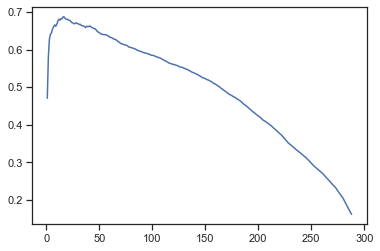

In [41]:
print('\nИзменение качества тестовой выборки в зависимости от кол-ва соседей:') 
plt.plot(n_range, gs_det.cv_results_['mean_test_score'])

### 

### Сравним метрики качества исходной и оптимальной моделей

In [42]:
# Обучение модели и оценка качества с учетом подобранных гиперпараметров
gs_det.best_estimator_.fit(X_train, Y_train)
target3_0 = gs_det.best_estimator_.predict(X_train)
target3_1 = gs_det.best_estimator_.predict(X_test)

In [43]:
# Новое качество модели
r2_score(Y_train, target3_0), r2_score(Y_test, target3_1)

(0.7464542346431304, 0.788148616621759)

In [44]:
# Качество модели до подбора гиперпараметров (10)
r2_score(Y_train, target_10Nt), r2_score(Y_test, target_10NN)

(0.7574355321123712, 0.7931839043022532)

In [45]:
# Качество модели до подбора гиперпараметров (2)
r2_score(Y_train, target_2Nt), r2_score(Y_test, target_2NN)

(0.881318879391868, 0.7030912267195688)